# Week 3
This week I:
- Altered the scaling on my get_data function so that each value has it's own individual scaler, rather than just using one MinMaxScaler object. I then added these scalers to the output dictionary so that I could unscale them later.
- Added a function to create a LSTM model.
- Added a function to predcit the future price based on the number of days in advance that I wanted to predict.
- Added a function to create a finished dataframe with the features from the original dataframe, as well as the predicted adjusted close values, and the actual adjusted close values. 
- Added a function to create a graph of the days vs. price (both the actual adjusted close, and predicted adjusted close)
- I then utilised these function on a few different tickers, outputing the predicted price, graph of the dates vs. price, loss, and mean absolute error for each one. Based on these outputted values, I made my buy/sell decisions for this week.   
 

In [3]:
pip install yahoo_fin

Note: you may need to restart the kernel to use updated packages.


In [4]:
pip install pandas numpy

Note: you may need to restart the kernel to use updated packages.


In [5]:
from yahoo_fin import stock_info as si

In [10]:
si.tickers_nasdaq()

['AACG',
 'AACI',
 'AACIU',
 'AACIW',
 'AADI',
 'AADR',
 'AAL',
 'AAME',
 'AAOI',
 'AAON',
 'AAPL',
 'AATC',
 'AAWW',
 'AAXJ',
 'ABCB',
 'ABCL',
 'ABCM',
 'ABEO',
 'ABGI',
 'ABIO',
 'ABMD',
 'ABNB',
 'ABOS',
 'ABSI',
 'ABST',
 'ABTX',
 'ABUS',
 'ABVC',
 'ACAD',
 'ACAH',
 'ACAHU',
 'ACAHW',
 'ACB',
 'ACBA',
 'ACBAU',
 'ACBAW',
 'ACBI',
 'ACCD',
 'ACER',
 'ACET',
 'ACEV',
 'ACEVU',
 'ACEVW',
 'ACGL',
 'ACGLN',
 'ACGLO',
 'ACHC',
 'ACHL',
 'ACHV',
 'ACIU',
 'ACIW',
 'ACKIT',
 'ACKIU',
 'ACKIW',
 'ACLS',
 'ACMR',
 'ACNB',
 'ACOR',
 'ACQR',
 'ACQRU',
 'ACQRW',
 'ACRS',
 'ACRX',
 'ACST',
 'ACT',
 'ACTD',
 'ACTDU',
 'ACTDW',
 'ACTG',
 'ACVA',
 'ACWI',
 'ACWX',
 'ACXP',
 'ADAG',
 'ADALU',
 'ADAP',
 'ADBE',
 'ADER',
 'ADERU',
 'ADERW',
 'ADES',
 'ADGI',
 'ADI',
 'ADIL',
 'ADILW',
 'ADMA',
 'ADMP',
 'ADN',
 'ADNWW',
 'ADOC',
 'ADOCR',
 'ADOCW',
 'ADP',
 'ADPT',
 'ADRE',
 'ADSK',
 'ADTN',
 'ADTX',
 'ADUS',
 'ADV',
 'ADVM',
 'ADVWW',
 'ADXN',
 'ADXS',
 'AEAC',
 'AEACU',
 'AEACW',
 'AEAEU',
 'AEHA'

In [6]:
pip install sklearn

Note: you may need to restart the kernel to use updated packages.


In [7]:
import numpy as np
from collections import deque 

In [8]:
features = ['adjclose', 'volume', 'open', 'high', 'low']

In [9]:
pip install tensorflow

Note: you may need to restart the kernel to use updated packages.


In [10]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split


In [42]:
def get_data(ticker, window=50, predict=1):
    df = si.get_data(ticker)
    output = {}
    output['original df'] = df.copy()

    for col in features: 
        if col not in features:
            return f'Missing {col}'
    
    if 'date' not in df.columns:
        df['date'] = df.index

    scalers = {}
    for feature in features:
        scaler = MinMaxScaler()
        df[feature] = scaler.fit_transform(np.expand_dims(df[feature].values, axis=1))
        scalers[feature] = scaler
    output['scalers'] = scalers
    
    df['predicted'] = df['adjclose'].shift(-predict)
    last_values = np.array(df[features].tail(predict)) 
    df.dropna(inplace=True)
 
    predicted_val = df['predicted'].values
    features_dates = df[features + ['date']].values
    d = deque(maxlen=window)
    window_seq = []

    for i in range(len(features_dates)):
        d.append(features_dates[i])
        if len(d) == window:
            window_seq.append([np.array(d), predicted_val[i]])
    
    # final feature values left after broken up into window sequences, and last values 
    # len(last_values) = (window + predict)
    last_values = list([seq[:len(features)] for seq in d]) + list(last_values) 
    last_values = np.array(last_values).astype(np.float32)
    output['last values'] = last_values

    x, y = [], []
    for X, Y in window_seq:
        x.append(X)
        y.append(Y)

    x = np.array(x)
    y = np.array(y)

    output['x train'], output['x test'], output['y train'], output['y test'] = train_test_split(x, y, test_size=.2)

    dates = output['x test'][:, -1, -1]
    output['test df'] = output['original df'].loc[dates]
    # print(type(output['test df']))
    output['test df'] = output['test df'][~output['test df'].index.duplicated()]
    output['x train'] = output['x train'][:, :, : len(features)].astype(np.float32)
    output['x test'] = output['x test'][:, :, : len(features)].astype(np.float32)
    
    return output
    

In [35]:
get_data('AAPL')

(51, 5)
(8219, 50, 5)
(8219,)
(2055, 50, 5)
(2055,)


{'original df':                   open        high         low       close    adjclose  \
 1980-12-12    0.513400    0.515628    0.513400    0.513400    0.478481   
 1980-12-15    0.486614    0.488842    0.486614    0.486614    0.453517   
 1980-12-16    0.450900    0.453128    0.450900    0.450900    0.420232   
 1980-12-17    0.462057    0.464285    0.462057    0.462057    0.430630   
 1980-12-18    0.475457    0.477685    0.475457    0.475457    0.443119   
 ...                ...         ...         ...         ...         ...   
 2021-12-03  164.020004  164.960007  159.720001  161.839996  161.839996   
 2021-12-06  164.289993  167.879898  164.279999  165.320007  165.320007   
 2021-12-07  169.080002  171.580002  168.339996  171.179993  171.179993   
 2021-12-08  172.125000  175.960007  170.699997  175.080002  175.080002   
 2021-12-09  174.910004  176.750000  173.919998  174.559998  174.559998   
 
                  volume ticker  
 1980-12-12  117258400.0   AAPL  
 1980-12-15   4

In [14]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import ModelCheckpoint, TensorBoard
import pandas as pd

In [43]:
def make_LSTM_model(window_seq_length, num_features, num_layers=4, units=45, dropout=0.2):
    rnn = Sequential()
    for layer in range(num_layers):
        if layer == 0:
            rnn.add(LSTM(units, return_sequences=True, input_shape=(window_seq_length, num_features)))
        elif layer == num_layers -1:
            rnn.add(LSTM(units))
        else:
            rnn.add(LSTM(units, return_sequences=True))
        rnn.add(Dropout(dropout))
    rnn.add(Dense(units=1))
    rnn.compile(optimizer='adam', metrics='mean_absolute_error', loss='huber_loss')
    return rnn

In [16]:
import os
import time

In [49]:
ticker = 'AMZN'
window = 50
predict = 1
layers = 4
units = 256
dropout = 0.2
date = time.strftime("%Y-%m-%d")
eps = 10
b_size=64

ticker_filename = os.path.join('data', f'{date}_{ticker}.csv')
model_name = f'{date}_{ticker}'

data = get_data(ticker, window, predict)
data['original df'].to_csv(ticker_filename)

model = make_LSTM_model(window, len(features), layers, units, dropout)
m_checkpoint = ModelCheckpoint(filepath=os.path.join('model_checkpoint', model_name + '.h5'), 
                                save_best_only=True, save_weights_only=True, verbose=1)
tensorboard = TensorBoard(log_dir=os.path.join('tensorboard', model_name))

model_history = model.fit(data['x train'], data['y train'], batch_size=b_size, epochs=eps, validation_data=(data['x test'], data['y test']), 
                            callbacks=[m_checkpoint, tensorboard], verbose=1)
                            


Epoch 1/10
77/77 [==============================] - ETA: 0s - loss: 0.0020 - mean_absolute_error: 0.0250
Epoch 00001: val_loss improved from inf to 0.00011, saving model to model_checkpoint/2021-12-10_AMZN.h5
77/77 [==============================] - 49s 558ms/step - loss: 0.0020 - mean_absolute_error: 0.0250 - val_loss: 1.0804e-04 - val_mean_absolute_error: 0.0075
Epoch 2/10
77/77 [==============================] - ETA: 0s - loss: 2.6387e-04 - mean_absolute_error: 0.0107
Epoch 00002: val_loss improved from 0.00011 to 0.00007, saving model to model_checkpoint/2021-12-10_AMZN.h5
77/77 [==============================] - 42s 546ms/step - loss: 2.6387e-04 - mean_absolute_error: 0.0107 - val_loss: 6.8359e-05 - val_mean_absolute_error: 0.0053
Epoch 3/10
77/77 [==============================] - ETA: 0s - loss: 3.3093e-04 - mean_absolute_error: 0.0118
Epoch 00003: val_loss did not improve from 0.00007
77/77 [==============================] - 41s 529ms/step - loss: 3.3093e-04 - mean_absolute_err

In [48]:
os.mkdir('tensorboard')
os.mkdir('model_checkpoint')
os.mkdir('data')

In [53]:
import matplotlib.pyplot as plt

In [45]:
def make_prediction(m, d):
    last_values = d['last values'][-window:]
    last_values = np.expand_dims(last_values, 0)
    print(np.shape(last_values))
    prediction = m.predict(last_values)
    predicted_price = d['scalers']['adjclose'].inverse_transform(prediction)[0][0]
    return predicted_price

In [46]:
def get_finished_df(m, d):
    x_test = d['x test']
    y_test = d['y test']

    y_prediction = m.predict(x_test)
    y_test = np.squeeze(d['scalers']['adjclose'].inverse_transform(np.expand_dims(y_test, axis=0)))
    y_prediction = np.squeeze(d['scalers']['adjclose'].inverse_transform(y_prediction))
    
    test_df = d['test df']

    test_df[f'actual adjclose {predict}'] = y_test
    test_df[f'adjclose {predict}'] = y_prediction
    test_df.sort_index(inplace=True)
    finished_df = test_df
    
    return finished_df


In [47]:
def plot(df):
    plt.plot(df[f'actual adjclose {predict}'], c='b')
    plt.plot(df[f'adjclose {predict}'], c='r')
    plt.xlabel('Days')
    plt.ylabel('Price')
    plt.legend(['Actual Price', 'Predicted Price'])
    plt.show()

In [50]:
model_path = os.path.join('model_checkpoint', model_name) + '.h5' 
model.load_weights(model_path)


In [51]:
loss, mae = model.evaluate(data['x test'], data['y test'], verbose=1)
mean_abs_error = data['scalers']['adjclose'].inverse_transform([[mae]])[0][0]

39/39 [==============================] - 3s 86ms/step - loss: 6.1073e-05 - mean_absolute_error: 0.0049


In [24]:
print(type(data['test df']))

<class 'pandas.core.frame.DataFrame'>


(1, 50, 5)
Future price after 1 days is 3557.92$
Loss: 6.107318768044934e-05
Mean absolute error: 19.610782351977047


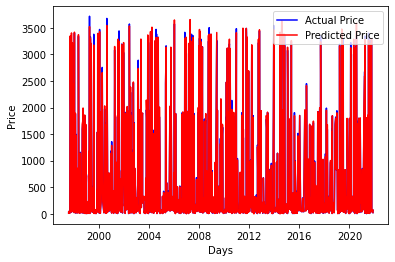

In [54]:
finished_df = get_finished_df(model, data)
future_price = make_prediction(model, data)
print(f'Future price after {predict} days is {future_price:.2f}$')
print(f'Loss: {loss}')
print(f'Mean absolute error: {mean_abs_error}')
plot(finished_df)

In [55]:
csv_result_folder = 'csv_results'
if not os.path.isdir(csv_result_folder):
    os.mkdir(csv_result_folder)
csv_filename = os.path.join(csv_result_folder, model_name + '.csv')
finished_df.to_csv(csv_filename)


In [56]:
ticker = 'AAPL'
window = 50
predict = 7
layers = 4
units = 256
dropout = 0.2
date = time.strftime("%Y-%m-%d")
eps = 10
b_size=64

ticker_filename = os.path.join('data', f'{date}_{ticker}.csv')
model_name = f'{date}_{ticker}'

data = get_data(ticker, window, predict)
data['original df'].to_csv(ticker_filename)

model = make_LSTM_model(window, len(features), layers, units, dropout)
m_checkpoint = ModelCheckpoint(filepath=os.path.join('model_checkpoint', model_name + '.h5'), 
                                save_best_only=True, save_weights_only=True, verbose=1)
tensorboard = TensorBoard(log_dir=os.path.join('tensorboard', model_name))

model_history = model.fit(data['x train'], data['y train'], batch_size=b_size, epochs=eps, validation_data=(data['x test'], data['y test']), 
                            callbacks=[m_checkpoint, tensorboard], verbose=1)

Epoch 1/10
129/129 [==============================] - ETA: 0s - loss: 0.0013 - mean_absolute_error: 0.0213
Epoch 00001: val_loss improved from inf to 0.00036, saving model to model_checkpoint/2021-12-10_AAPL.h5
129/129 [==============================] - 72s 510ms/step - loss: 0.0013 - mean_absolute_error: 0.0213 - val_loss: 3.6250e-04 - val_mean_absolute_error: 0.0092
Epoch 2/10
129/129 [==============================] - ETA: 0s - loss: 6.5195e-04 - mean_absolute_error: 0.0161
Epoch 00002: val_loss did not improve from 0.00036
129/129 [==============================] - 67s 519ms/step - loss: 6.5195e-04 - mean_absolute_error: 0.0161 - val_loss: 3.8283e-04 - val_mean_absolute_error: 0.0096
Epoch 3/10
129/129 [==============================] - ETA: 0s - loss: 7.2061e-04 - mean_absolute_error: 0.0168
Epoch 00003: val_loss did not improve from 0.00036
129/129 [==============================] - 69s 537ms/step - loss: 7.2061e-04 - mean_absolute_error: 0.0168 - val_loss: 5.4339e-04 - val_mean_

65/65 [==============================] - 5s 72ms/step - loss: 2.9084e-04 - mean_absolute_error: 0.0065
(1, 50, 5)
Future price after 7 days is 164.11$
Loss: 0.0002908439782913774
Mean absolute error: 2.2731914387669265


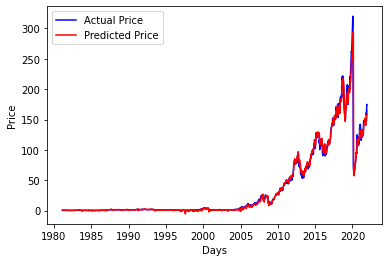

In [57]:
model_path = os.path.join('model_checkpoint', model_name) + '.h5' 
model.load_weights(model_path)
loss, mae = model.evaluate(data['x test'], data['y test'], verbose=1)
mean_abs_error = data['scalers']['adjclose'].inverse_transform([[mae]])[0][0]
finished_df = get_finished_df(model, data)
future_price = make_prediction(model, data)
print(f'Future price after {predict} days is {future_price:.2f}$')
print(f'Loss: {loss}')
print(f'Mean absolute error: {mean_abs_error}')
plot(finished_df)

csv_result_folder = 'csv_results'
if not os.path.isdir(csv_result_folder):
    os.mkdir(csv_result_folder)
csv_filename = os.path.join(csv_result_folder, model_name + '.csv')
finished_df.to_csv(csv_filename)


In [58]:
ticker = 'BLK'
window = 50
predict = 7
layers = 4
units = 256
dropout = 0.2
date = time.strftime("%Y-%m-%d")
eps = 10
b_size=64

ticker_filename = os.path.join('data', f'{date}_{ticker}.csv')
model_name = f'{date}_{ticker}'

data = get_data(ticker, window, predict)
data['original df'].to_csv(ticker_filename)

model = make_LSTM_model(window, len(features), layers, units, dropout)
m_checkpoint = ModelCheckpoint(filepath=os.path.join('model_checkpoint', model_name + '.h5'), 
                                save_best_only=True, save_weights_only=True, verbose=1)
tensorboard = TensorBoard(log_dir=os.path.join('tensorboard', model_name))

model_history = model.fit(data['x train'], data['y train'], batch_size=b_size, epochs=eps, validation_data=(data['x test'], data['y test']), 
                            callbacks=[m_checkpoint, tensorboard], verbose=1)

Epoch 1/10
70/70 [==============================] - ETA: 0s - loss: 0.0056 - mean_absolute_error: 0.0525
Epoch 00001: val_loss improved from inf to 0.00025, saving model to model_checkpoint/2021-12-10_BLK.h5
70/70 [==============================] - 44s 520ms/step - loss: 0.0056 - mean_absolute_error: 0.0525 - val_loss: 2.4791e-04 - val_mean_absolute_error: 0.0143
Epoch 2/10
70/70 [==============================] - ETA: 0s - loss: 3.9104e-04 - mean_absolute_error: 0.0171
Epoch 00002: val_loss did not improve from 0.00025
70/70 [==============================] - 41s 585ms/step - loss: 3.9104e-04 - mean_absolute_error: 0.0171 - val_loss: 9.0936e-04 - val_mean_absolute_error: 0.0287
Epoch 3/10
70/70 [==============================] - ETA: 0s - loss: 4.3010e-04 - mean_absolute_error: 0.0183
Epoch 00003: val_loss did not improve from 0.00025
70/70 [==============================] - 40s 572ms/step - loss: 4.3010e-04 - mean_absolute_error: 0.0183 - val_loss: 2.8999e-04 - val_mean_absolute_erro

35/35 [==============================] - 3s 83ms/step - loss: 1.8529e-04 - mean_absolute_error: 0.0113
(1, 50, 5)
Future price after 7 days is 918.58$
Loss: 0.00018528985674493015
Mean absolute error: 19.254658405068692


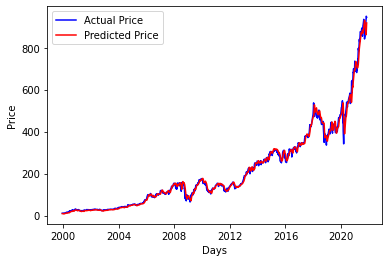

In [59]:
model_path = os.path.join('model_checkpoint', model_name) + '.h5' 
model.load_weights(model_path)
loss, mae = model.evaluate(data['x test'], data['y test'], verbose=1)
mean_abs_error = data['scalers']['adjclose'].inverse_transform([[mae]])[0][0]
finished_df = get_finished_df(model, data)
future_price = make_prediction(model, data)
print(f'Future price after {predict} days is {future_price:.2f}$')
print(f'Loss: {loss}')
print(f'Mean absolute error: {mean_abs_error}')
plot(finished_df)

csv_result_folder = 'csv_results'
if not os.path.isdir(csv_result_folder):
    os.mkdir(csv_result_folder)
csv_filename = os.path.join(csv_result_folder, model_name + '.csv')
finished_df.to_csv(csv_filename)